# Qwen2-VL vision language model

https://arxiv.org/pdf/2409.12191

https://github.com/QwenLM/Qwen2-VL

- Naive Dynamic Resolution: Unlike before, Qwen2-VL can handle arbitrary image resolutions, mapping them into a dynamic number of visual tokens, offering a more human-like visual processing experience.
- Multimodal Rotary Position Embedding (M-ROPE): Decomposes positional embedding into parts to capture 1D textual, 2D visual, and 3D video positional information, enhancing its multimodal processing capabilities.

![image.png](qwen2vl.png)

In [2]:
# %pip install  "transformers>=4.45" "torch==2.4" "torchvision" "qwen-vl-utils" "Pillow" "gradio>=4.36" --extra-index-url https://download.pytorch.org/whl/cpu
# %pip install  "openvino>=2024.4.0" "nncf>=2.13.0"

In [1]:
from pathlib import Path
import requests

if not Path("ov_qwen2_vl.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/qwen2-vl/ov_qwen2_vl.py")
    open("ov_qwen2_vl.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

In [2]:
from ov_qwen2_vl import model_selector

model_id = model_selector()

model_id

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


Dropdown(description='Model:', options=('Qwen/Qwen2-VL-2B-Instruct', 'Qwen/Qwen2-VL-7B-Instruct'), value='Qwen…

In [3]:
print(f"Selected {model_id.value}")
pt_model_id = model_id.value
model_dir = Path(pt_model_id.split("/")[-1])

Selected Qwen/Qwen2-VL-2B-Instruct


In [4]:
from ov_qwen2_vl import convert_qwen2vl_model

# uncomment these lines to see model conversion code
#convert_qwen2vl_model??

In [5]:
import nncf

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_ASYM,
    "group_size": 128,
    "ratio": 1.0,
}

convert_qwen2vl_model(pt_model_id, model_dir, compression_configuration)

⌛ Qwen/Qwen2-VL-2B-Instruct conversion started. Be patient, it may takes some time.
⌛ Load Original model


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Original model successfully loaded
⌛ Convert Input embedding model
✅ Input embedding model successfully converted
⌛ Convert Image embedding model


C:\Users\User\.conda\envs\openvino\Lib\site-packages\transformers\modeling_utils.py:5006: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


⌛ Weights compression with int4_asym mode started
INFO:nncf:Statistics of the bitwidth distribution:
+----------------+-----------------------------+----------------------------------------+
|   Num bits (N) | % all parameters (layers)   | % ratio-defining parameters (layers)   |
+================+=============================+========================================+
|              8 | 1% (1 / 130)                | 0% (0 / 129)                           |
+----------------+-----------------------------+----------------------------------------+
|              4 | 99% (129 / 130)             | 100% (129 / 129)                       |
+----------------+-----------------------------+----------------------------------------+


Output()

✅ Weights compression finished
✅ Image embedding model successfully converted
⌛ Convert Language model


C:\Users\User\.conda\envs\openvino\Lib\site-packages\transformers\cache_utils.py:458: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  or len(self.key_cache[layer_idx]) == 0  # the layer has no cache
C:\Users\User\.conda\envs\openvino\Lib\site-packages\transformers\modeling_attn_mask_utils.py:281: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif sliding_window is None or key_value_length < sliding_window:
C:\Users\User\.conda\envs\openvino\Lib\site-packages\transformers\models\qwen2_vl\modeling_qwen2_vl.py:1329: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be in

✅ Language model successfully converted
⌛ Weights compression with int4_asym mode started
INFO:nncf:Statistics of the bitwidth distribution:
+----------------+-----------------------------+----------------------------------------+
|   Num bits (N) | % all parameters (layers)   | % ratio-defining parameters (layers)   |
+================+=============================+========================================+
|              8 | 15% (1 / 197)               | 0% (0 / 196)                           |
+----------------+-----------------------------+----------------------------------------+
|              4 | 85% (196 / 197)             | 100% (196 / 196)                       |
+----------------+-----------------------------+----------------------------------------+


Output()

✅ Weights compression finished
✅ Qwen/Qwen2-VL-2B-Instruct model conversion finished. You can find results in Qwen2-VL-2B-Instruct


In [6]:
from ov_qwen2_vl import OVQwen2VLModel

In [7]:
from notebook_utils import device_widget

device = device_widget(default="AUTO", exclude=["NPU"])

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [8]:
model = OVQwen2VLModel(model_dir, device.value)

In [17]:
import pprint
from PIL import Image
from transformers import AutoProcessor, AutoTokenizer
from qwen_vl_utils import process_vision_info
from transformers import TextStreamer

# Describe Image

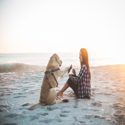

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Question:
Describe this image.
Answer:
The image depicts a woman sitting on a sandy beach with a large dog. The dog is sitting on its hind legs, and the woman is reaching out to high-five the dog. The background shows the ocean with waves crashing into the shore, and the sky is clear with a soft glow, suggesting either sunrise or sunset. The woman is wearing a plaid shirt and black pants, and the dog is wearing a colorful harness. The scene conveys a sense of companionship and relaxation.


In [22]:
min_pixels = 256 * 28 * 28
max_pixels = 1280 * 28 * 28
processor = AutoProcessor.from_pretrained(model_dir, min_pixels=min_pixels, max_pixels=max_pixels)

if processor.chat_template is None:
    tok = AutoTokenizer.from_pretrained(model_dir)
    processor.chat_template = tok.chat_template

example_image_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
example_image_path = Path("demo.jpeg")

if not example_image_path.exists():
    Image.open(requests.get(example_image_url, stream=True).raw).save(example_image_path)

image = Image.open(example_image_path)
question = "Describe this image."

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": f"file://{example_image_path}",
            },
            {"type": "text", "text": question},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

display(image.resize(size=(125,125)))
print("Question:")
print(question)
print("Answer:")

generated_ids = model.generate(**inputs, max_new_tokens=100, streamer=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True))

In [24]:
example_image_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
example_image_path = Path("demo.jpeg")

if not example_image_path.exists():
    Image.open(requests.get(example_image_url, stream=True).raw).save(example_image_path)

image = Image.open(example_image_path)

In [25]:
image.size

(2048, 1365)

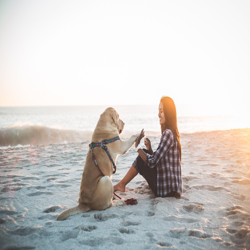

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Question:
Enumerate main objects in this image. only a label for object and number. Only objects in the front
Answer:
1. Dog
2. Person
3. Sand
4. Ocean
5. Sunlight


In [23]:
question = "Enumerate main objects in this image. only a label for object and number. Only objects in the front"

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": f"file://{example_image_path}",
            },
            {"type": "text", "text": question},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

display(image.resize(size=(250,250)))
print("Question:")
print(question)
print("Answer:")

generated_ids = model.generate(**inputs, max_new_tokens=100, streamer=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True))

# Interpret a plot 

In [13]:
image = Image.open("29774.jpeg")
question = "Describe this image."
example_image_path = "29774.jpeg"
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": f"file://{example_image_path}",
            },
            {"type": "text", "text": question},
        ],
    }
]

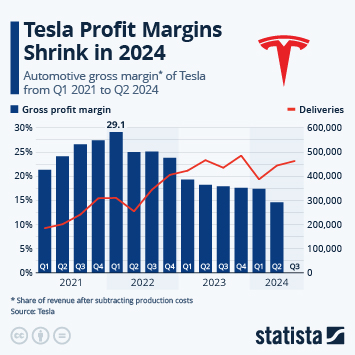

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Question:
Describe this image.
Answer:
The image is a bar chart titled "Tesla Profit Margins Shrink in 2024." The chart compares the gross profit margins of Tesla from Q1 2021 to Q2 2024. The bars represent the percentage of revenue after subtracting production costs, while the red line represents the number of deliveries.

### Description:
1. **Title and Legend**: The chart has a title that reads "Tesla Profit Margins Shrink in 2024


In [14]:
# Preparation for inference
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

display(image)
print("Question:")
print(question)
print("Answer:")

generated_ids = model.generate(**inputs, max_new_tokens=100, streamer=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True))

In [26]:
# Messages containing a video and a text query
example_video_path = "v_BaseballPitch_g22_c04.avi"
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": f"file://{example_video_path}",
                "max_pixels": 360 * 420,
                "fps": 1.0,
            },
            {"type": "text", "text": "Describe this video."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)


# Inference
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
pprint.pprint(output_text)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


['The video depicts a baseball game in progress. A batter is preparing to '
 'swing at a pitch, while a catcher and an umpire are positioned behind him. '
 'The batter is wearing a white uniform with a green shirt, and he is holding '
 'a baseball bat. The catcher is wearing a black uniform with a white shirt, '
 'and he is crouched behind the batter, ready to catch the ball if needed. The '
 'umpire is standing behind the catcher, observing the play. The background '
 'shows a green field with a blue wall, and there is a scoreboard displaying '
 'the current score. The video captures the intense moment of a baseball game, '
 'highlighting the']


# OCR Image

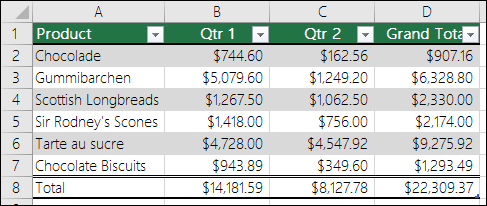

In [19]:
image = Image.open("table.png")
image

In [20]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": "Extract all text from this table and format it like a table"},
        ],
    }
]


# Preprocess the inputs
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)


# Inference: Generation of the output
output_ids = model.generate(**inputs, max_new_tokens=512)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
pprint.pprint(output_text)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


['Certainly! Here is the table formatted as a table:\n'
 '\n'
 '```\n'
 '| Product | Qtr 1 | Qtr 2 | Grand Total |\n'
 '|---------|-------|-------|-------------|\n'
 '| Chocolade | $744.60 | $162.56 | $907.16 |\n'
 '| Gummibarchen | $5,079.60 | $1,249.20 | $6,328.80 |\n'
 '| Scottish Longbreads | $1,267.50 | $1,062.50 | $2,330.00 |\n'
 "| Sir Rodney's Scones | $1,418.00 | $756.00 | $2,174.00 |\n"
 '| Tarte au sucre | $4,728.00 | $4,547.92 | $9,275.92 |\n'
 '| Chocolate Biscuits | $943.89 | $349.60 | $1,293.49 |\n'
 '| Total | $14,181.59 | $8,127.78 | $22,309.37 |\n'
 '```\n'
 '\n'
 'I have added a header row and formatted the table to make it easier to read.']
